# Test signal generation and NFT processing

### Import libraries and functions

In [13]:
import FNFTpy as fpy
import numpy as np
import timeit
import matplotlib
import matplotlib.pyplot as plt

import signal_handling.signal_generation as sg
import signal_handling.signal_processing as sp
import signal_handling.ssfm as ssfm
import nft_handling.nft_analyse as nft

### Generate signal

In [85]:
modulation_type = "16qam"
n_car = 1
t_symb = 1.

number_of_symbols = 2 ** 7
np_symb = 16
n_lateral_symbols = 32
n_lateral = n_lateral_symbols * np_symb

p_dbm = 0  # signal average power in dBm
dt = t_symb / np_symb

q = sg.create_signal(number_of_symbols, p_dbm, modulation_type, n_car, t_symb=t_symb, np_symb=np_symb, n_lateral_symbols=n_lateral_symbols)
n_add = 2 ** 6 * np_symb
q = sg.add_lateral(q, n_add)

# create time and spectrum
n_t = len(q)
# t = np.array([(i - (n_t - 1) / 2) * dt for i in range(n_t)])
t = np.array([(i - n_t / 2) * dt for i in range(n_t)])
t_span = t[-1] - t[0]

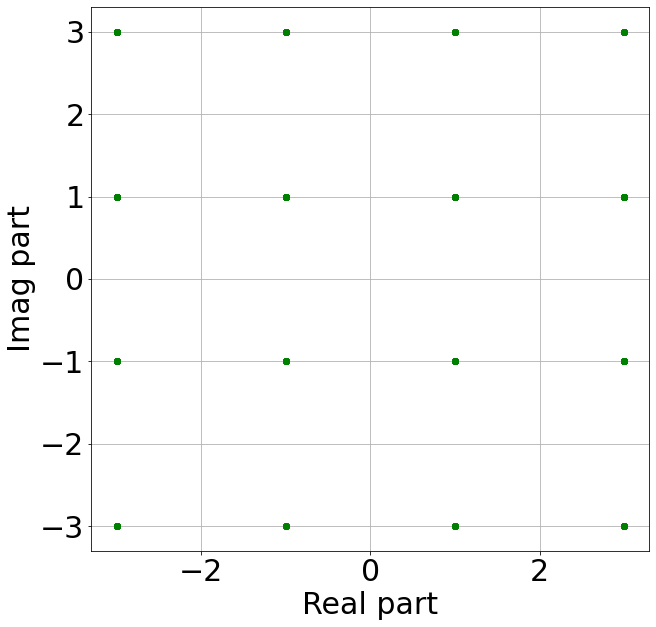

In [86]:
# points_orig = np.array(sg.get_constellation_point(data, type=modulation_type))
points_restored = np.array(sg.get_points_wdm(q, t_symb, np_symb, None, None, n_carriers=n_car, mod_type=modulation_type, n_lateral=n_lateral + n_add))
constellation_scale = sg.get_scale_coef(points_restored, modulation_type)
points_restored = constellation_scale * points_restored
# points_diff = points_orig - points_restored
# print(len(points_orig), len(points_restored))
# print(np.max(np.absolute(points_orig - points_restored)))
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(10,10))
# axs.plot(np.real(points_orig), np.imag(points_orig), color='green', marker='d', linewidth=0)
axs.plot(np.real(points_restored), np.imag(points_restored), color='green', marker='o', linewidth=0)
# axs.plot(np.real(points_diff), np.imag(points_diff), color='green', marker='o', linewidth=0)
axs.set_xlabel('Real part')
axs.set_ylabel('Imag part')
axs.grid(True)

### Calculate signal propagation

In [87]:
z_80km_nd = sg.z_km_to_nd(80, t_symb=14.8)
n_z_span = 1
# ssfm propagation
# z_prop = 100.0
beta2 = -1.0
gamma = 1.0

q_prop_total = np.zeros((n_z_span, len(q)), dtype=complex)
q_prop = q

n_z_prop = 2 ** 9
for k_span in range(n_z_span):
    # time_start = time.time()
    q_prop = ssfm.fiber_propogate(q_prop, t_span, z_80km_nd, n_z_prop, gamma=gamma, beta2=beta2)
    q_prop_total[k_span] = q_prop
    # time_end = time.time()
    # print('Time, s:', time_end - time_start)

In [99]:
result_dbp_nft = nft.make_dbp_nft(q_prop, t - (t[-1] + t[0]) / 2, z_80km_nd,
                                  xi_upsampling=16, inverse_type='tib',
                                  fnft_type=0,
                                  print_sys_message=True)

q_nft = result_dbp_nft['q_total']

Number of discrete eigenvalues: 28


mean error: 0.01187421752909119
max error: 0.024033443240828244


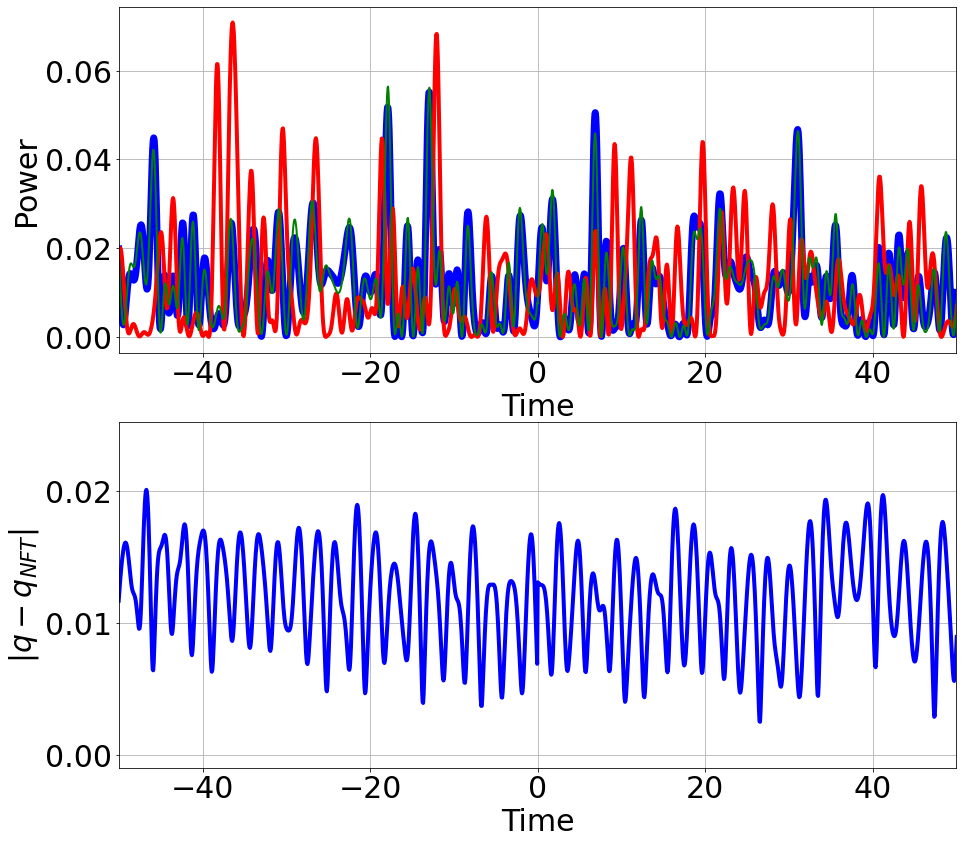

In [100]:
fig, axs = plt.subplots(2, 1, figsize=(15,14))
axs[0].plot(t, np.power(np.absolute(q), 2), 'blue', linewidth=7)
axs[0].plot(t, np.power(np.absolute(q_prop), 2), 'red', linewidth=4)
axs[0].plot(t, np.power(np.absolute(q_nft), 2), 'green', linewidth=2)
axs[0].set_xlim(-50, 50)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)


axs[1].plot(t, np.absolute(q - q_nft), 'blue', linewidth=4)
axs[1].set_xlim(-50, 50)
axs[1].set_xlabel('Time')
axs[1].set_ylabel(r'$|q - q_{NFT}|$')
axs[1].grid(True)

print("mean error:", np.mean(np.absolute(q - q_nft)))
print("max error:", np.max(np.absolute(q - q_nft)))